# Bitcoin Prices Prediction Project

## Introduction

Bitcoin is an extremely controversial asset. While some fans claim that it will one day replace all currency, some critics also boldly claim that it is simply a fad and will eventually be as worthless as tulips. With that said, all parties agree that it is an extremely volatile asset. 

However, while the price of this asset can jump or decline by upwards of 10% a day, a true Data Scientist might ask the question, "Can we use Machine Learning to predict these massive swings?". This project is dedicated to answering that question.

To accomplish this, we will not only incorporate the historical price of bitcoin into our model, but we will also perform some sentiment analysis as part of bitcoin's volatility is very much driven by how the masses are feeling about it on any given day. We will also utilize Gradient Boosting (XGBoost) to construct our model and backtesting to validate our model.

### Data Harvesting

To start, we'll use the wikipedia page about Bitcoin to act as a proxy to judge the sentiment of the masses using Sentiment Analysis.

In [1]:
# We first import the mwclient package to allow us to work with Wikipedia
import mwclient
import time

site = mwclient.Site("en.wikipedia.org")  # Connect to Wikipedia
page = site.pages["Bitcoin"]  # Navigate to the Bitcoin page

In [2]:
# We then use the number of revisions as a proxy for interest
revisions = list(page.revisions())  # Fetches page's revisions

In [3]:
# Let's take a look at the most recent revision to the Bitcoin page
revisions[0]

OrderedDict([('revid', 1114403330),
             ('parentid', 1114126683),
             ('user', 'Chidgk1'),
             ('timestamp',
              time.struct_time(tm_year=2022, tm_mon=10, tm_mday=6, tm_hour=9, tm_min=41, tm_sec=5, tm_wday=3, tm_yday=279, tm_isdst=-1)),
             ('comment',
              '/* Environmental impact */ Moved content from [[Bitcoin#Environmental_impact]] to the lead of [[Environmental impact of bitcoin]] and excerpted back as discussed at [[Talk:Bitcoin#Excerpting_Environmental_impact_of_bitcoin]]')])

We first notice that our dictionary is an Ordered dictionary. We wish to sort such that the first edit to the Bitcoin page is the first edit in our list

In [4]:
# We sort our Ordered Dictionary from oldest to most recent
revisions = sorted(revisions, key=lambda rev: rev["timestamp"])

In [5]:
# Let's check to make sure our edit worked
revisions[0]

OrderedDict([('revid', 275832581),
             ('parentid', 0),
             ('user', 'Pratyeka'),
             ('timestamp',
              time.struct_time(tm_year=2009, tm_mon=3, tm_mday=8, tm_hour=16, tm_min=41, tm_sec=7, tm_wday=6, tm_yday=67, tm_isdst=-1)),
             ('comment', 'creation (stub)')])

The first revision came on March 8th, 2009! If only I had known about BTC when I was 10...

### Sentiment Analysis

Recall that we wish to leverage these revisions to act as a proxy for consumer/trader sentiment surrounding BTC as we hypothesize that sentiment heavily influence the price of Bitcoin. To do this, we can find the total number of edits per day and utilize deep learning models to construct sentiments surrounding BTC per day!

In [6]:
# We first import the transformers library to help create our sentiment analyzer
from transformers import pipeline
sentiment_pipeline = pipeline("sentiment-analysis")

# We then create a function that assigns a sentiment score based upon the first 250 characters
def find_sentiment(text):
    sent = sentiment_pipeline([text[:250]])[0]  # Element extracted is a dict where value is score and label for type of sentiment
    score = sent["score"]  # Score of sentiment
    if sent["label"] == "NEGATIVE":  # If the label revision is a negative sentiment
        score *= -1  # Convert the score to a negative
    return score

C:\Python\anaconda3\lib\site-packages\tensorflow\core\framework\tensor_shape_pb2.py:18: DeprecationWarning: Call to deprecated create function FileDescriptor(). Note: Create unlinked descriptors is going to go away. Please use get/find descriptors from generated code or query the descriptor_pool.
  DESCRIPTOR = _descriptor.FileDescriptor(
C:\Python\anaconda3\lib\site-packages\tensorflow\core\framework\tensor_shape_pb2.py:36: DeprecationWarning: Call to deprecated create function FieldDescriptor(). Note: Create unlinked descriptors is going to go away. Please use get/find descriptors from generated code or query the descriptor_pool.
  _descriptor.FieldDescriptor(
C:\Python\anaconda3\lib\site-packages\tensorflow\core\framework\tensor_shape_pb2.py:43: DeprecationWarning: Call to deprecated create function FieldDescriptor(). Note: Create unlinked descriptors is going to go away. Please use get/find descriptors from generated code or query the descriptor_pool.
  _descriptor.FieldDescriptor(

In [7]:
# Let's test out this function by passing in a few strings and analyzing the sentiment score
find_sentiment("I love you")

0.9998656511306763

In [8]:
# ^ a very positive score...what about a negative comment?
find_sentiment("I hate you")

-0.9991129040718079

We now wish to loop over our revision history and count up the number of revisions in a day. We then will pass in the text of our revisions into our sentiment analysis function to get an average sentiment score per day for our model to use later in this project.

In [9]:
edits = {}  # dictionary to hold our edits
for rev in revisions:
    date = time.strftime("%Y-%m-%d", rev["timestamp"])  # Converts named tuples in revisions into time strings
    
    
    if date not in edits:
        edits[date] = dict(sentiments=list(), edit_count=0) # If date is not in our dict, we initialize it with a pair of keys
        
    edits[date]["edit_count"] += 1  # Increase our edit count
    
    comment = rev.get("comment","")  # Extract our comment
    edits[date]["sentiments"].append(find_sentiment(comment))  # Passes in our comment into our function from earlier and stores it

In [10]:
# Our sentiments are a list. We need to convert it to use it in a DataFrame later
from statistics import mean
for key in edits:  # Loops through edits dictionary
    if len(edits[key]["sentiments"]) > 0:  # If there are actually comments and we can extract sentiment
        edits[key]["sentiment"] = mean(edits[key]["sentiments"])
        edits[key]["neg_sentiment"] = len([s for s in edits[key]["sentiments"] if s < 0]) / len(edits[key]["sentiments"]) # Percentage of comments with negative sentiments
    else:
        edits[key]["sentiment"] = 0
        edits[key]["neg_sentiment"] = 0
        
    del edits[key]["sentiments"]  # Helps us create a dictionary by dropping the sentiment value


In [11]:
# Let's examine what this dictionary looks like. 
# We should see three values per date key. The number of revisions for a particular day, the sentiment, and the percentage of negative sentiments.
edits

{'2009-03-08': {'edit_count': 4,
  'sentiment': -0.550524964928627,
  'neg_sentiment': 0.75},
 '2009-08-05': {'edit_count': 1,
  'sentiment': 0.7481210231781006,
  'neg_sentiment': 0.0},
 '2009-08-06': {'edit_count': 2,
  'sentiment': 0.9957457184791565,
  'neg_sentiment': 0.0},
 '2009-08-14': {'edit_count': 1,
  'sentiment': 0.930020809173584,
  'neg_sentiment': 0.0},
 '2009-10-13': {'edit_count': 2,
  'sentiment': -0.2275008261203766,
  'neg_sentiment': 0.5},
 '2009-11-18': {'edit_count': 1,
  'sentiment': 0.8839507102966309,
  'neg_sentiment': 0.0},
 '2009-12-08': {'edit_count': 1,
  'sentiment': -0.9869275689125061,
  'neg_sentiment': 1.0},
 '2009-12-17': {'edit_count': 1,
  'sentiment': -0.9975171089172363,
  'neg_sentiment': 1.0},
 '2010-02-23': {'edit_count': 1,
  'sentiment': -0.9994946718215942,
  'neg_sentiment': 1.0},
 '2010-03-18': {'edit_count': 1,
  'sentiment': 0.8758772015571594,
  'neg_sentiment': 0.0},
 '2010-04-13': {'edit_count': 4,
  'sentiment': 0.8443553894758224

We now proceed to converting our sentiment analysis into a dataframe. We can then incorporate this into our machine learning model. 

In [12]:
import pandas as pd

edits_df = pd.DataFrame.from_dict(edits, orient="index")

In [13]:
# Let's check to make sure each row is a separate data and all 3 columns count correctly
edits_df.head()

,edit_count,sentiment,neg_sentiment
2009-03-08,4,-0.550525,0.75
2009-08-05,1,0.748121,0.00
2009-08-06,2,0.995746,0.00
2009-08-14,1,0.930021,0.00
2009-10-13,2,-0.227501,0.50


In [14]:
# We now convert our index to a datetime index
edits_df.index = pd.to_datetime(edits_df.index)

Notice how in our dataframe, there are a lot of gaps in terms of time span between edits. Recall that bitcoin is traded non-stop, so we would like a dataframe of revisions with 0 time gaps.

In [15]:
# We loop through our dataframe to create a continuous time series
from datetime import datetime
dates = pd.date_range(start="2009-03-08", end=datetime.today())  # We first create a datetime index to fill in gaps

In [16]:
# We then use the index above to create a continuous dataframe
edits_df = edits_df.reindex(dates, fill_value=0)  # We fill in days with no record with 0
edits_df

,edit_count,sentiment,neg_sentiment
2009-03-08,4,-0.550525,0.750000
2009-03-09,0,0.000000,0.000000
2009-03-10,0,0.000000,0.000000
2009-03-11,0,0.000000,0.000000
2009-03-12,0,0.000000,0.000000
...,...,...,...
2022-10-02,3,-0.328583,0.666667
2022-10-03,0,0.000000,0.000000
2022-10-04,3,-0.236808,0.666667
2022-10-05,0,0.000000,0.000000


Perfect! Our dataframe is not missing any days! However, notice that there are a lot of values of 0, which will not be very useful for our algorithm. 

To address this issue, we'll instead use a rolling average approach instead, and apply it to all 3 columns. This will give us a proxy to see what was the interest in bitcoint per month (30-day rolling average).

In [17]:
# Create a rolling average dataframe
rolling_edits = edits_df.rolling(30).mean()
rolling_edits

,edit_count,sentiment,neg_sentiment
2009-03-08,NaN,NaN,NaN
2009-03-09,NaN,NaN,NaN
2009-03-10,NaN,NaN,NaN
2009-03-11,NaN,NaN,NaN
2009-03-12,NaN,NaN,NaN
...,...,...,...
2022-10-02,1.033333,-0.101027,0.241111
2022-10-03,1.033333,-0.101027,0.241111
2022-10-04,1.133333,-0.108921,0.263333
2022-10-05,1.133333,-0.108921,0.263333


In [18]:
# We then remove the early rows with missing data
rolling_edits = rolling_edits.dropna()
rolling_edits

,edit_count,sentiment,neg_sentiment
2009-04-06,0.133333,-0.018351,0.025000
2009-04-07,0.000000,0.000000,0.000000
2009-04-08,0.000000,0.000000,0.000000
2009-04-09,0.000000,0.000000,0.000000
2009-04-10,0.000000,0.000000,0.000000
...,...,...,...
2022-10-02,1.033333,-0.101027,0.241111
2022-10-03,1.033333,-0.101027,0.241111
2022-10-04,1.133333,-0.108921,0.263333
2022-10-05,1.133333,-0.108921,0.263333


In [19]:
# We then export this dataframe to a csv file in preparation for model constructions
rolling_edits.to_csv("wikipedia_edits.csv")

### Bitcoin Price Data Harvesting and Analysis

In order to grab historical information for bitcoin, we will use the yfinance package to connect to Yahoo! Finance.

In [20]:
import yfinance as yf
import os

In [21]:
# We first create a ticker object to download the price history of BTC
btc_ticker = yf.Ticker("BTC-USD")

In [22]:
# We then generate a table for the price history of bitcoin
btc = btc_ticker.history(period="max")

In [23]:
# We again convert this index to a datetime object
btc.index = pd.to_datetime(btc.index, format="%Y-%m-%d")
btc.index = btc.index.tz_localize(None)
btc

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
2014-09-17,465.864014,468.174011,452.421997,457.334015,21056800,0,0
2014-09-18,456.859985,456.859985,413.104004,424.440002,34483200,0,0
2014-09-19,424.102997,427.834991,384.532013,394.795990,37919700,0,0
2014-09-20,394.673004,423.295990,389.882996,408.903992,36863600,0,0
2014-09-21,408.084991,412.425995,393.181000,398.821014,26580100,0,0
...,...,...,...,...,...,...,...
2022-10-02,19311.849609,19370.308594,18970.621094,19044.107422,20765955327,0,0
2022-10-03,19044.068359,19653.542969,19025.226562,19623.580078,30484729489,0,0
2022-10-04,19623.583984,20380.343750,19523.839844,20336.843750,35887278685,0,0


In [24]:
# We also do not care about a few column from this table. We delete those here
del btc["Stock Splits"]
del btc["Dividends"]

# We then convert columns to lower case
btc.columns = [c.lower() for c in btc.columns]

<AxesSubplot:xlabel='Date'>

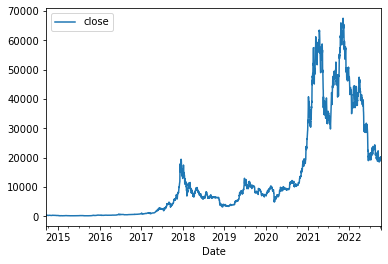

In [25]:
# Let's get an idea of what the historical brice of bitcoin has been
import matplotlib.pyplot as plt
%matplotlib inline
btc.plot.line(y="close", use_index=True)

In [26]:
# We now read in our wikipedia file from earlier
wiki = pd.read_csv("wikipedia_edits.csv", index_col=0, parse_dates=True)

We now are ready to merge our BTC Historical Dataframe and our wikipedia Dataframe into one. We will do so by a left join on the index of the BTC Historical Dataframe.

### Preprocessing

In [27]:
# We first merge our dataframes together
btc = btc.merge(wiki, left_index=True, right_index=True)

In [28]:
btc

,open,high,low,close,volume,edit_count,sentiment,neg_sentiment
2014-09-17,465.864014,468.174011,452.421997,457.334015,21056800,5.033333,-0.232191,0.532718
2014-09-18,456.859985,456.859985,413.104004,424.440002,34483200,5.066667,-0.232760,0.532718
2014-09-19,424.102997,427.834991,384.532013,394.795990,37919700,5.200000,-0.235415,0.549385
2014-09-20,394.673004,423.295990,389.882996,408.903992,36863600,5.200000,-0.233185,0.549385
2014-09-21,408.084991,412.425995,393.181000,398.821014,26580100,5.233333,-0.204017,0.532718
...,...,...,...,...,...,...,...,...
2022-10-02,19311.849609,19370.308594,18970.621094,19044.107422,20765955327,1.033333,-0.101027,0.241111
2022-10-03,19044.068359,19653.542969,19025.226562,19623.580078,30484729489,1.033333,-0.101027,0.241111
2022-10-04,19623.583984,20380.343750,19523.839844,20336.843750,35887278685,1.133333,-0.108921,0.263333
2022-10-05,20335.900391,20343.748047,19801.800781,20160.716797,33223790572,1.133333,-0.108921,0.263333


### Model Construction

We now proceed to constructing our machine learning model. Now, for this project, instead of trying to create a regression problem by predicting the price, we are instead going to opt for a classification problem. 

We are going to try to predict whether the price will go up or down. This is due to the fact that, even if we have a really good MSE score for a regression model, it might be the case that the MSE is to the downside, and so we would have lost money. Instead, telling us if the price will go up or down is much more useful.

In [29]:
# We first take the close price and shift it backward by a day, creating a new column as well
btc["tomorrow"] = btc["close"].shift(-1)
btc.head()

,open,high,low,close,volume,edit_count,sentiment,neg_sentiment,tomorrow
2014-09-17,465.864014,468.174011,452.421997,457.334015,21056800,5.033333,-0.232191,0.532718,424.440002
2014-09-18,456.859985,456.859985,413.104004,424.440002,34483200,5.066667,-0.232760,0.532718,394.795990
2014-09-19,424.102997,427.834991,384.532013,394.795990,37919700,5.200000,-0.235415,0.549385,408.903992
2014-09-20,394.673004,423.295990,389.882996,408.903992,36863600,5.200000,-0.233185,0.549385,398.821014
2014-09-21,408.084991,412.425995,393.181000,398.821014,26580100,5.233333,-0.204017,0.532718,402.152008


In [30]:
# We then define our target column. 1 is price went up, 0 is price went down
btc["target"] = (btc["tomorrow"] > btc["close"]).astype(int)

In [31]:
# Let's look at the distribution of our values
btc["target"].value_counts()

1    1576
0    1366
Name: target, dtype: int64

This is nice...we don't have an imbalanced classification problem

In [32]:
# We'll first create a "quick and dirty" model and then improve
from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier(n_estimators=100, min_samples_split=50, random_state=1)

In [33]:
# We now create our training and test sets
train = btc.iloc[:-200]  # Split until the last two hundred days
test = btc.iloc[-200:]

features = ["close", "volume", "open", "high", "low", "edit_count", "sentiment", "neg_sentiment"] # List of features to train on
rf.fit(train[features], train["target"])  # Fit our model to the training data

RandomForestClassifier(min_samples_split=50, random_state=1)

In [34]:
# We will use a precision score to evaluate our model
from sklearn.metrics import precision_score

predictions = rf.predict(test[features])  # Create our predictions
predictions = pd.Series(predictions, index=test.index)  # Transform it to a Series
rough_score = precision_score(test["target"], predictions) 
print("Our rough draft model accurately predicted the BTC price direction {}% of the time".format(rough_score*100))

Our rough draft model accurately predicted the BTC price direction 46.496815286624205% of the time


### Model Improvements with Feature Engineering

We will first begin with backtesting. This will enable us to respect the order of the data while still getting as many predictions as possible. We will do so by defining a function that will perform backtesting for us.

In [54]:
def predict(train, test, features, model): # Initialize our function with parameters
    model.fit(train[features], train["target"])
    predictions = model.predict(test[features])  # Create our predictions
    predictions = pd.Series(predictions, index=test.index, name="predictions")  # Transform it to a Series
    combined = pd.concat([test["target"], predictions], axis=1)
    return combined

In [55]:
# We now define our backtesting function
def backtest(data, model, features, start=1095, step=150):  # Initialize our function with parameters. Goal is to generate new predictions every 6 months (start, end)
    all_predictions = []  # A list to hold our predictions
    
    for i in range(start, data.shape[0], step): # We iterate through the data
        train = data.iloc[0:i].copy()  # Avoid setting with copy warning
        test = data.iloc[i:(i+step)].copy()  # Split off the test set from training set
        predictions = predict(train, test, features, model)  # We call our prediction function defined above
        
        all_predictions.append(predictions)  # We append our predictions to our list
    return pd.concat(all_predictions)  # We concatentate our predictions

In [56]:
from xgboost import XGBClassifier

# We create an XGBoost Classifier with 200 models to boost
model = XGBClassifier(random_state=1, learning_rate=.1, n_estimators=200)
predictions = backtest(btc, model, features)

In [57]:
improved_score = precision_score(predictions["target"], predictions["predictions"])
print("After performing backtesting, our model is about {}% accurate, an improvement from the ~46-47% earlier".format(improved_score*100))

After performing backtesting, our model is about 49.90974729241877% accurate, an improvement from the ~46-47% earlier


We now improve our score with generating new features by computing rolling trends over the last period.

In [58]:
# We start by defining a function to analyze rolling trends within our data
def compute_rolling(btc):
    horizons = [2, 7, 60, 365]  # Days to use for trends analysis
    new_predictors = ["close", "sentiment", "neg_sentiment"]
    
    for horizon in horizons:  # We first iterate over our time horizons
        rolling_averages = btc.rolling(horizon, min_periods=1).mean()  # We then compute the rolling mean
        
        ratio_column = f"close_ratio_{horizon}" # Defines a new column name for each horizon
        btc[ratio_column] = btc["close"] / rolling_averages["close"] # Values finds the ratio between current close price and price over the past horizons.
        
        edit_column = f"edit_{horizon}"  # Same idea for our edit counts
        btc[edit_column] = rolling_averages["edit_count"]
        
        rolling = btc.rolling(horizon, closed="left", min_periods=1).mean() # Ensures we don't include current target
        trend_column = f"trend_{horizon}"
        btc[trend_column] = rolling["target"]
        
        new_predictors += [ratio_column, trend_column, edit_column]  # Append our new features to our feature list
    return btc, new_predictors
        

In [51]:
# We then run our function above
btc, new_predictors = compute_rolling(btc.copy())  # Prevents SWCW

In [52]:
# Let's take a look at our new dataframe
btc

,open,high,low,close,volume,edit_count,sentiment,neg_sentiment,tomorrow,target,...,trend_2,close_ratio_7,edit_7,trend_7,close_ratio_60,edit_60,trend_60,close_ratio_365,edit_365,trend_365
2014-09-17,465.864014,468.174011,452.421997,457.334015,21056800,5.033333,-0.232191,0.532718,424.440002,0,...,NaN,1.000000,5.033333,NaN,1.000000,5.033333,NaN,1.000000,5.033333,NaN
2014-09-18,456.859985,456.859985,413.104004,424.440002,34483200,5.066667,-0.232760,0.532718,394.795990,0,...,0.0,0.962696,5.050000,0.000000,0.962696,5.050000,0.000000,0.962696,5.050000,0.000000
2014-09-19,424.102997,427.834991,384.532013,394.795990,37919700,5.200000,-0.235415,0.549385,408.903992,1,...,0.0,0.927789,5.100000,0.000000,0.927789,5.100000,0.000000,0.927789,5.100000,0.000000
2014-09-20,394.673004,423.295990,389.882996,408.903992,36863600,5.200000,-0.233185,0.549385,398.821014,0,...,0.5,0.970419,5.125000,0.333333,0.970419,5.125000,0.333333,0.970419,5.125000,0.333333
2014-09-21,408.084991,412.425995,393.181000,398.821014,26580100,5.233333,-0.204017,0.532718,402.152008,1,...,0.5,0.956729,5.146667,0.250000,0.956729,5.146667,0.250000,0.956729,5.146667,0.250000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-10-02,19311.849609,19370.308594,18970.621094,19044.107422,20765955327,1.033333,-0.101027,0.241111,19623.580078,1,...,0.0,0.986588,0.923810,0.428571,0.909233,0.439444,0.466667,0.506893,0.881461,0.479452
2022-10-03,19044.068359,19653.542969,19025.226562,19623.580078,30484729489,1.033333,-0.101027,0.241111,20336.843750,1,...,0.5,1.013601,0.952381,0.428571,0.939146,0.453889,0.483333,0.523407,0.881187,0.479452
2022-10-04,19623.583984,20380.343750,19523.839844,20336.843750,35887278685,1.133333,-0.108921,0.263333,20160.716797,0,...,1.0,1.041022,0.990476,0.571429,0.975579,0.470000,0.483333,0.543575,0.881187,0.479452
2022-10-05,20335.900391,20343.748047,19801.800781,20160.716797,33223790572,1.133333,-0.108921,0.263333,19993.072266,0,...,0.5,1.026497,1.028571,0.428571,0.969300,0.486111,0.483333,0.540107,0.881187,0.476712


In [59]:
# We now perform backtesting again
predictions = backtest(btc, model, new_predictors)

In [60]:
xgb_score = precision_score(predictions["target"], predictions["predictions"])
print("Our model after performing feature engineering is about {}% accurate.".format(xgb_score*100))

Our model after performing feature engineering is about 53.788687299893276% accurate.


## Conclusion

After a lot of hardwork, we were able to create a model that accurately predicts if Bitcoin will go up in price the next day about 54% of the time. Hypothetically, this is better than just flipping a coin, but we can definitely make some improvements into this model.

For example, BTC tends to be a futures indicator for the US Stock Market, implying that the market and BTC are positively correlated. We could create a new feature column that looks at the index of the US stock market each day. 

We could also look to incorporate other crypto currencies into our model as well, or even look to scrape tweets or news articles to append to our sentiment analysis.